# Introduction

This Notebooks is a join notebook from both the prepare_data and pytorch-bst in order to be run in google colab.

# Prepare data section

In [103]:
import pandas as pd
import torch
from tqdm import tqdm
import math
from urllib.request import urlretrieve
from zipfile import ZipFile
import os
import numpy as np
from math import sqrt
from numpy.random import choice
import math
import random
from matplotlib import pyplot as plt
from ast import literal_eval


## Settings

### Transform the movie ratings data into sequences

First, let's sort the the ratings data using the `unix_timestamp`, and then group the
`movie_id` values and the `rating` values by `user_id`.

The output DataFrame will have a record for each `user_id`, with two ordered lists
(sorted by rating datetime): the movies they have rated, and their ratings of these movies.

Now, let's split the `movie_ids` list into a set of sequences of a fixed length.
We do the same for the `ratings`. Set the `sequence_length` variable to change the length
of the input sequence to the model. You can also change the `step_size` to control the
number of sequences to generate for each user.

# Here is where we change the data into different ratings

* ratings_data -> no changes to the sequence
* inputed_ratings_data -> inputed ratings
* random_ratings_data 

Truth -> random sequences

Toy Story III - Toy Story II - Toy Story -  Toy Story IV

Toy Story - Toy Story II - Toy Story III - Toy Story IV
Toy Story II - Toy Story III - Titanic - Toy Story IV

### Sequence creation code

In [43]:
def create_sequences(values, window_size, step_size):
  # used for creating sequences
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

# Methods for sequence perturbation and perturbation calculation

### Random Inputation Methods

### Corruption Measurement

Counts the difference between the original sequence and the "perturbed" sequence

In [10]:
def measure_corruption(df, column1 , column2 ):
  perc_change = []
  n_corrupted = []
  for index, row in df.iterrows():
    a = row[f'{column1}']
    b= row[f'{column2}']
    res = 0
    for i in range(len(a)):
      if a[i] != b[i]:
        res +=1
    perc_change.append(round(res/len(a)*100, 2))
    n_corrupted.append(res)
  df['percentage_change'] = perc_change
  df['movies_corrupted'] = n_corrupted
  return df

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


FileNotFoundError: ignored

In [30]:
truth = pd.read_csv('/content/drive/MyDrive/547_Project/data/truth.csv')

In [129]:
inputed_ratings_data_10 = pd.read_csv('/content/drive/MyDrive/547_Project/data/inputed_ratings_data_10.csv')
inputed_ratings_data_20 = pd.read_csv('/content/drive/MyDrive/547_Project/data/inputed_ratings_data_20.csv')
inputed_ratings_data_30 = pd.read_csv('/content/drive/MyDrive/547_Project/data/inputed_ratings_data_30.csv')
inputed_ratings_data_40 = pd.read_csv('/content/drive/MyDrive/547_Project/data/inputed_ratings_data_40.csv')
inputed_ratings_data_50 = pd.read_csv('/content/drive/MyDrive/547_Project/data/inputed_ratings_data_50.csv')

In [105]:
random_ratings_data_10 = pd.read_csv('/content/drive/MyDrive/547_Project/data/random_ratings_data_10.csv')
random_ratings_data_20 = pd.read_csv('/content/drive/MyDrive/547_Project/data/random_ratings_data_20.csv')
random_ratings_data_30 = pd.read_csv('/content/drive/MyDrive/547_Project/data/random_ratings_data_30.csv')
random_ratings_data_40 = pd.read_csv('/content/drive/MyDrive/547_Project/data/random_ratings_data_40.csv')
random_ratings_data_50 = pd.read_csv('/content/drive/MyDrive/547_Project/data/random_ratings_data_50.csv')

# First Procedure (1) 

First separate movie list into window sequences, then perturb the window sequences

In [77]:
#inputed_ratings_data_10['movie_ids'] = inputed_ratings_data_10['movie_ids'].apply(lambda x: literal_eval(x))


In [119]:
def corruption_results(df, col1):
## TRAINING DATASET
  df[f'{col1}'] = df[f'{col1}'].apply(lambda x: literal_eval(x))
  df['movie_ids'] = df['movie_ids'].apply(lambda x: literal_eval(x))
  sequence_length = 8
  step_size = 1
  # create sequences for train data
  random.seed(0)
  df[f'{col1}'] = df[f'{col1}'].apply(
      lambda ids: create_sequences(ids, sequence_length, step_size)
  )
  random.seed(0)
  df.movie_ids = df.movie_ids.apply(
      lambda ids: create_sequences(ids, sequence_length, step_size)
  )

  del df["timestamps"]

  df_p = df[["user_id", f"{col1}"]].explode(
      f"{col1}", ignore_index=True
  )
  df_t = df[[ "movie_ids"]].explode(
      "movie_ids", ignore_index=True
  )
  df_final = pd.concat([df_p, df_t], axis=1)
  df_final = measure_corruption(df_final, col1 , 'movie_ids' )
  return df_final

In [ ]:
random_ratings_data_10

In [130]:
res_inp_10 = corruption_results(inputed_ratings_data_10, 'inp_movie_ids')
res_inp_20 = corruption_results(inputed_ratings_data_20, 'inp_movie_ids')
res_inp_30 = corruption_results(inputed_ratings_data_30, 'inp_movie_ids')
res_inp_40 = corruption_results(inputed_ratings_data_40, 'inp_movie_ids')
res_inp_50 = corruption_results(inputed_ratings_data_50, 'inp_movie_ids')
res_ran_10 = corruption_results(random_ratings_data_10, 'random_movie_ids')
res_ran_20 = corruption_results(random_ratings_data_20, 'random_movie_ids')
res_ran_30 = corruption_results(random_ratings_data_30, 'random_movie_ids')
res_ran_40 = corruption_results(random_ratings_data_40, 'random_movie_ids')
res_ran_50 = corruption_results(random_ratings_data_50, 'random_movie_ids')

In [131]:
results_corruption = pd.DataFrame.from_dict({
    "Perturbation": ["Inputed 10%",
                     "Inputed 20%",
                     "Inputed 30%",
                     "Inputed 40%",
                     "Inputed 50%",
                     "Order 10%",
                     "Order 20%",
                     "Order 30%",
                     "Order 40%",
                     "Order 50%"],
    "Average Corruption": [np.mean(res_inp_10.percentage_change),
                           np.mean(res_inp_20.percentage_change),
                           np.mean(res_inp_30.percentage_change),
                           np.mean(res_inp_40.percentage_change),
                           np.mean(res_inp_50.percentage_change),
                           np.mean(res_ran_10.percentage_change),
                           np.mean(res_ran_20.percentage_change),
                           np.mean(res_ran_30.percentage_change),
                           np.mean(res_ran_40.percentage_change),
                           np.mean(res_ran_50.percentage_change)]
 })

In [147]:
results_corruption.to_csv('results_corruption.csv')

In [143]:
# # Write the DataFrame to CSV file.
from google.colab import drive
#drive.mount('/content/gdrive')
with open("/content/gdrive/My Drive/data/results_corruption.csv", 'w') as f:
  results_corruption.to_csv(f)

FileNotFoundError: ignored

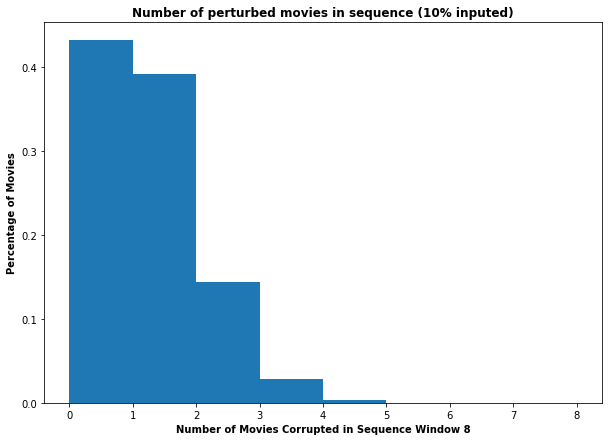

In [148]:
a = res_inp_10.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (10% inputed)', 
               fontweight ='bold')
# Show plot
plt.show()

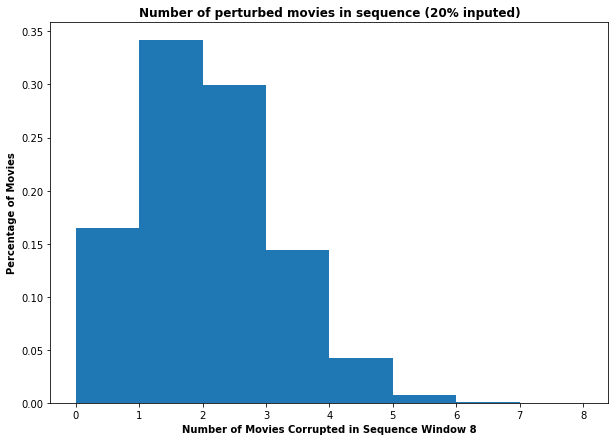

In [150]:
a = res_inp_20.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (20% inputed)', 
               fontweight ='bold')
# Show plot
plt.show()

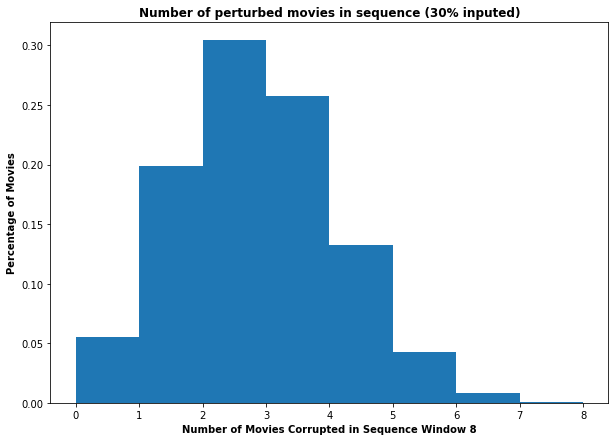

In [151]:
a = res_inp_30.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (30% inputed)', 
               fontweight ='bold')
# Show plot
plt.show()

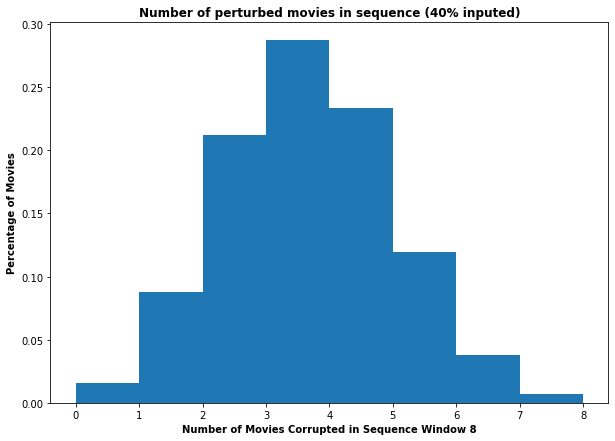

In [152]:
a = res_inp_40.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (40% inputed)', 
               fontweight ='bold')
# Show plot
plt.show()

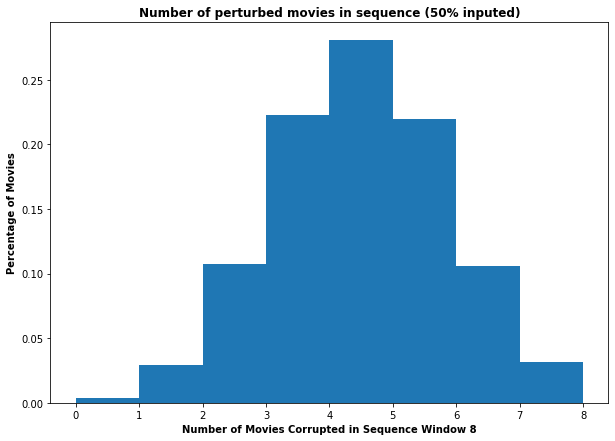

In [153]:
a = res_inp_50.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (50% inputed)', 
               fontweight ='bold')
# Show plot
plt.show()

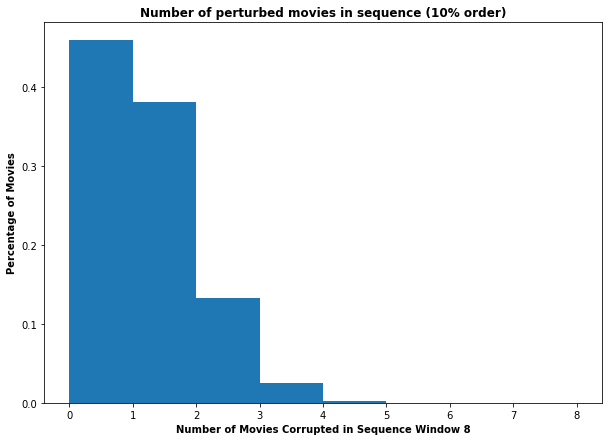

In [154]:
a = res_ran_10.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (10% order)', 
               fontweight ='bold')
# Show plot
plt.show()

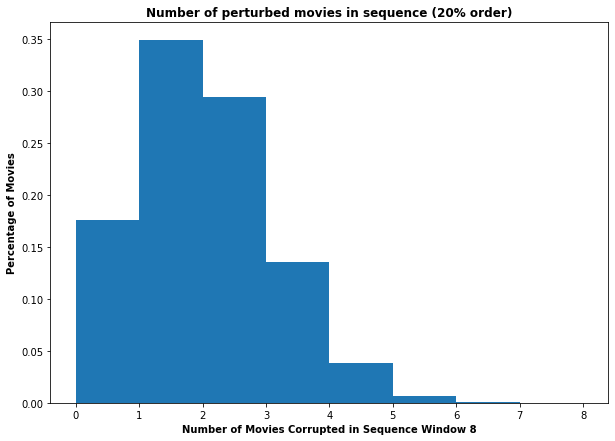

In [155]:
a = res_ran_20.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (20% order)', 
               fontweight ='bold')
# Show plot
plt.show()

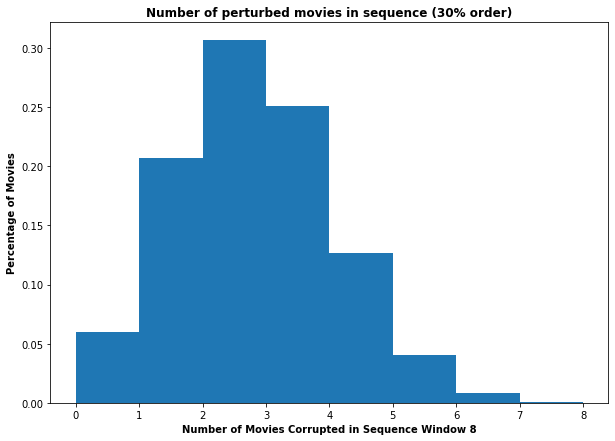

In [156]:
a = res_ran_30.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (30% order)', 
               fontweight ='bold')
# Show plot
plt.show()

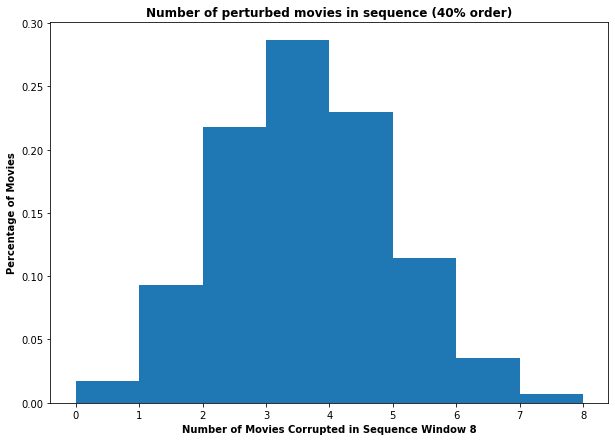

In [157]:
a = res_ran_40.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (40% order)', 
               fontweight ='bold')
# Show plot
plt.show()

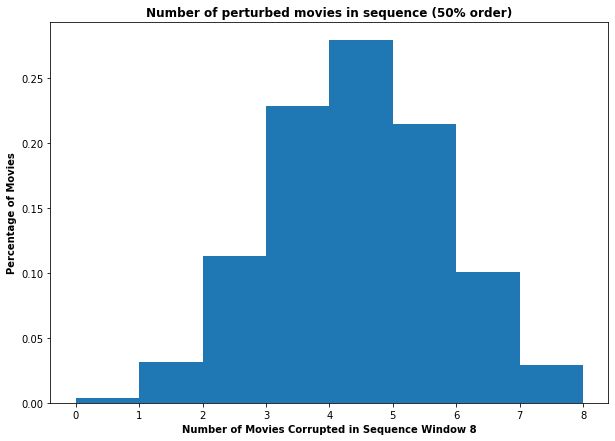

In [158]:
a = res_ran_50.movies_corrupted

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0,1,2,3,4,5,6,7,8], density=True)
ax.set_xlabel('Number of Movies Corrupted in Sequence Window 8', 
               fontweight ='bold')
ax.set_ylabel('Percentage of Movies', 
               fontweight ='bold')
ax.set_title('Number of perturbed movies in sequence (50% order)', 
               fontweight ='bold')
# Show plot
plt.show()

In [42]:
inputed_ratings_data_10.inp_movie_ids[1]

["['597', ",
 "'597', '",
 "597', '8",
 "97', '85",
 "7', '858",
 "', '858'",
 ", '858',",
 " '858', ",
 "'858', '",
 "858', '7",
 "58', '74",
 "8', '743",
 "', '743'",
 ", '743',",
 " '743', ",
 "'743', '",
 "743', '1",
 "43', '12",
 "3', '121",
 "', '1210",
 ", '1210'",
 " '1210',",
 "'1210', ",
 "1210', '",
 "210', '1",
 "10', '19",
 "0', '194",
 "', '1948",
 ", '1948'",
 " '1948',",
 "'1948', ",
 "1948', '",
 "948', '2",
 "48', '23",
 "8', '231",
 "', '2312",
 ", '2312'",
 " '2312',",
 "'2312', ",
 "2312', '",
 "312', '3",
 "12', '37",
 "2', '375",
 "', '3751",
 ", '3751'",
 " '3751',",
 "'3751', ",
 "3751', '",
 "751', '1",
 "51', '12",
 "1', '128",
 "', '1282",
 ", '1282'",
 " '1282',",
 "'1282', ",
 "1282', '",
 "282', '3",
 "82', '32",
 "2', '323",
 "', '3230",
 ", '3230'",
 " '3230',",
 "'3230', ",
 "3230', '",
 "230', '2",
 "30', '28",
 "0', '285",
 "', '2858",
 ", '2858'",
 " '2858',",
 "'2858', ",
 "2858', '",
 "858', '2",
 "58', '21",
 "8', '211",
 "', '2112",
 ", '2112'",

In [ ]:
# Import Drive API and authenticate.
# from google.colab import drive

# # Mount your Drive to the Colab VM.
# drive.mount('/gdrive')

# # Write the DataFrame to CSV file.
# with open('/gdrive/My Drive/547 Project/data/train_data_final.csv', 'w') as f:
#   train_data_final.to_csv(f)

In [ ]:
test_data.movie_ids[1][0]

'597'

In [ ]:
list_selection = []
all_movies_set = set(movies.movie_id.to_list())

for index, row in test_data.iterrows():
  user_movies_sequence_set = set(row['movie_ids'])
  difference_set = all_movies_set - user_movies_sequence_set
  list_selection.append(list(difference_set))

test_data['other_movies'] = list_selection

<ipython-input-161-108fe9dd6692>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['other_movies'] = list_selection


In [ ]:
# we keep a copy for second procedure
test_data_p2 = test_data.copy(deep=True)

In [ ]:
## TEST DATASET
sequence_length = 8
step_size = 1

# create sequences for train data
random.seed(0)

test_data.movie_ids = test_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

random.seed(0)

test_data.ratings = test_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

# del train_data["timestamps"]

test_data_movies = test_data[["user_id", "movie_ids", "other_movies"]].explode(
    "movie_ids", ignore_index=True
)
test_data_rating = test_data[["ratings"]].explode("ratings", ignore_index=True)
test_data_transformed = pd.concat([test_data_movies, test_data_rating], axis=1)
test_data_transformed = test_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)

del test_data_transformed["zip_code"]

test_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

test_data_final = test_data_transformed[['user_id','sequence_movie_ids'	,'sequence_ratings',	'sex',	'age_group',	'occupation']]

In [ ]:
# Import Drive API and authenticate.
# from google.colab import drive

# # Mount your Drive to the Colab VM.
# drive.mount('/gdrive')

# # Write the DataFrame to CSV file.
# with open('/gdrive/My Drive/547 Project/data/test_data_final.csv', 'w') as f:
#   test_data_final.to_csv(f)

In [ ]:
test_data_transformed

,user_id,sequence_movie_ids,other_movies,sequence_ratings,sex,age_group,occupation
0,10,"[597, 858, 743, 1210, 1948, 2312, 3751, 1282]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[4, 3, 3, 4, 4, 5, 5, 5]",0,3,1
1,10,"[858, 743, 1210, 1948, 2312, 3751, 1282, 551]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[3, 3, 4, 4, 5, 5, 5, 3]",0,3,1
2,10,"[743, 1210, 1948, 2312, 3751, 1282, 551, 2858]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[3, 4, 4, 5, 5, 5, 3, 3]",0,3,1
3,10,"[1210, 1948, 2312, 3751, 1282, 551, 2858, 2033]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[4, 4, 5, 5, 5, 3, 3, 3]",0,3,1
4,10,"[1948, 2312, 3751, 1282, 551, 2858, 2033, 3155]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[4, 5, 5, 5, 3, 3, 3, 5]",0,3,1
...,...,...,...,...,...,...,...
141626,998,"[269, 2391, 1794, 3247, 2395, 2071, 2108, 2439]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[4, 4, 4, 5, 4, 5, 4, 4]",1,4,20
141627,998,"[2391, 1794, 3247, 2395, 2071, 2108, 2439, 2323]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[4, 4, 5, 4, 5, 4, 4, 5]",1,4,20
141628,998,"[1794, 3247, 2395, 2071, 2108, 2439, 2323, 356]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[4, 5, 4, 5, 4, 4, 5, 5]",1,4,20
141629,998,"[3247, 2395, 2071, 2108, 2439, 2323, 356, 2192]","[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[5, 4, 5, 4, 4, 5, 5, 5]",1,4,20


## Random Inputation

In [ ]:
# not necessary in this version
all_movies_set = set(movies.movie_id.to_list())

In [ ]:
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
# inpute 1 movie in sequence of 8
inputed_ratings_data_1 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings', 1, False) # we can change the percentage we want
inputed_ratings_data_1 = measure_corruption(inputed_ratings_data_1, "sequence_movie_ids", "inp_movie_ids")


In [ ]:
# inpute 2 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_2 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings', 2, False) # we can change the percentage we want
inputed_ratings_data_2 = measure_corruption(inputed_ratings_data_2, "sequence_movie_ids", "inp_movie_ids")

# inpute 3 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_3 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings',  3, False) # we can change the percentage we want
inputed_ratings_data_3 = measure_corruption(inputed_ratings_data_3, "sequence_movie_ids", "inp_movie_ids")

# inpute 4 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_4 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings',  4, False) # we can change the percentage we want
inputed_ratings_data_4 = measure_corruption(inputed_ratings_data_4, "sequence_movie_ids", "inp_movie_ids")

# inpute 5 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_5 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings',  5, False) # we can change the percentage we want
inputed_ratings_data_5 = measure_corruption(inputed_ratings_data_5, "sequence_movie_ids", "inp_movie_ids")

# inpute 6 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_6 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings',  6, False) # we can change the percentage we want
inputed_ratings_data_6 = measure_corruption(inputed_ratings_data_6, "sequence_movie_ids", "inp_movie_ids")

# inpute 7 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_7 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings',  7, False) # we can change the percentage we want
inputed_ratings_data_7 = measure_corruption(inputed_ratings_data_7, "sequence_movie_ids", "inp_movie_ids")

# inpute 8 movies in sequence of 8
random.seed(10)
p1_input = test_data_transformed.copy(deep=True)
inputed_ratings_data_8 = random_inputation1(p1_input,'sequence_movie_ids','sequence_ratings',  8, False) # we can change the percentage we want
inputed_ratings_data_8 = measure_corruption(inputed_ratings_data_8, "sequence_movie_ids", "inp_movie_ids")


In [ ]:
del inputed_ratings_data_1['other_movies']
del inputed_ratings_data_2['other_movies']
del inputed_ratings_data_3['other_movies']
del inputed_ratings_data_4['other_movies']
del inputed_ratings_data_5['other_movies']
del inputed_ratings_data_6['other_movies']
del inputed_ratings_data_7['other_movies']
del inputed_ratings_data_8['other_movies']

In [ ]:
# # Write the DataFrame to CSV file.
from google.colab import drive
drive.mount('/gdrive')
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_1.csv', 'w') as f:
  inputed_ratings_data_1.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_2.csv', 'w') as f:
  inputed_ratings_data_2.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_3.csv', 'w') as f:
  inputed_ratings_data_3.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_4.csv', 'w') as f:
  inputed_ratings_data_4.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_5.csv', 'w') as f:
  inputed_ratings_data_5.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_6.csv', 'w') as f:
  inputed_ratings_data_6.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_7.csv', 'w') as f:
  inputed_ratings_data_7.to_csv(f)  
with open('/gdrive/My Drive/547 Project/data/p1_inputed_ratings_data_8.csv', 'w') as f:
  inputed_ratings_data_8.to_csv(f)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Random sequence order perturbation

In [ ]:
order_ratings_data = ratings_data.copy(deep=True)

In [ ]:
df = order_ratings_data
i = 10
user_movies_sequence = df.movie_ids[i]
ratings = df.ratings[i]
n = len(user_movies_sequence)

In [ ]:
def shuffle(movie_sequence, ratings, count):
    '''Shuffles any n number of values in a list'''
    indices_to_shuffle = random.sample(range(len(movie_sequence)), k=count)
    old_indices = indices_to_shuffle.copy()
    random.shuffle(indices_to_shuffle)
    new_movie_sequence = movie_sequence.copy()
    new_ratings_sequence = ratings.copy()
    for index, value in enumerate(indices_to_shuffle):
        old_index = old_indices[index]
        new_movie_sequence[old_index] = movie_sequence[value]
        new_ratings_sequence[old_index] = ratings[value]
    
    return new_movie_sequence,new_ratings_sequence

In [ ]:
def random_shuffling(df,col1,col2, val, percentage = True):
  # takes in the dataframe where we will inpute the data as df
  # the all movies set is used so that we inpute movies that are not watched by the user
  # the percentage is the amount of perturbation to the list
  new_sequences = []
  new_rating_lists = []
  for index, row in df.iterrows():
    user_movies_sequence = row[f'{col1}']
    ratings = row[f'{col2}']
    n = len(user_movies_sequence)
    if percentage:
      n_shuffle = math.floor(n * val)
    else:
      n_shuffle = val
    new_seq, new_ratings = shuffle(user_movies_sequence, ratings, n_shuffle)
    new_sequences.append(new_seq)
    new_rating_lists.append(new_ratings)
  df['random_movie_ids'] = new_sequences
  df['random_ratings'] = new_rating_lists
  return df

# Sequence Creation

Was done before its stored in `test_data_transformed` or `test_data_final`

In [ ]:
test_data_final

,user_id,sequence_movie_ids,sequence_ratings,sex,age_group,occupation
0,10,"[597, 858, 743, 1210, 1948, 2312, 3751, 1282]","[4, 3, 3, 4, 4, 4, 5, 5]",0,3,1
1,10,"[858, 743, 1210, 1948, 2312, 3751, 1282, 551]","[1, 3, 4, 4, 5, 1, 5, 3]",0,3,1
2,10,"[743, 1210, 1948, 2312, 3751, 1282, 551, 2858]","[3, 4, 4, 5, 4, 5, 4, 3]",0,3,1
3,10,"[1210, 1948, 2312, 3751, 1282, 551, 2858, 2033]","[2, 4, 5, 5, 2, 3, 3, 3]",0,3,1
4,10,"[1948, 2312, 3751, 1282, 551, 2858, 2033, 3155]","[4, 5, 4, 5, 3, 4, 3, 5]",0,3,1
...,...,...,...,...,...,...
141626,998,"[269, 2391, 1794, 3247, 2395, 2071, 2108, 2439]","[4, 4, 5, 5, 4, 5, 4, 4]",1,4,20
141627,998,"[2391, 1794, 3247, 2395, 2071, 2108, 2439, 2323]","[4, 4, 4, 4, 5, 4, 4, 5]",1,4,20
141628,998,"[1794, 3247, 2395, 2071, 2108, 2439, 2323, 356]","[4, 1, 4, 5, 4, 1, 5, 5]",1,4,20
141629,998,"[3247, 2395, 2071, 2108, 2439, 2323, 356, 2192]","[5, 2, 5, 4, 4, 5, 5, 2]",1,4,20


In [ ]:
random.seed(10)
# randomize 2 movie in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_2 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 2, False ) # we can change the percentage we want
random_ratings_data_2 = measure_corruption(random_ratings_data_2, "sequence_movie_ids", "random_movie_ids")

In [ ]:
random_ratings_data_2[random_ratings_data_2['percentage_change']>0]

In [ ]:
random.seed(10)
# randomize 2 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_2 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 2, False ) # we can change the percentage we want
random_ratings_data_2 = measure_corruption(random_ratings_data_2, "sequence_movie_ids", "random_movie_ids")
random.seed(10)
# randomize 3 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_3 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 3, False ) # we can change the percentage we want
random_ratings_data_3 = measure_corruption(random_ratings_data_3, "sequence_movie_ids", "random_movie_ids")
random.seed(10)
# randomize 4 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_4 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 4, False ) # we can change the percentage we want
random_ratings_data_4 = measure_corruption(random_ratings_data_4, "sequence_movie_ids", "random_movie_ids")
random.seed(10)
# randomize 5 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_5 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 5, False ) # we can change the percentage we want
random_ratings_data_5 = measure_corruption(random_ratings_data_5, "sequence_movie_ids", "random_movie_ids")
random.seed(10)
# randomize 6 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_6 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 6, False ) # we can change the percentage we want
random_ratings_data_6 = measure_corruption(random_ratings_data_6, "sequence_movie_ids", "random_movie_ids")
random.seed(10)
# randomize 7 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_7 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 7, False ) # we can change the percentage we want
random_ratings_data_7 = measure_corruption(random_ratings_data_7, "sequence_movie_ids", "random_movie_ids")
random.seed(10)
# randomize 8 movies in sequence of 8
random_df = test_data_final.copy(deep=True)
random_ratings_data_8 = random_shuffling(random_df,'sequence_movie_ids','sequence_ratings', 8, False ) # we can change the percentage we want
random_ratings_data_8 = measure_corruption(random_ratings_data_8, "sequence_movie_ids", "random_movie_ids")

In [ ]:
print(np.mean(random_ratings_data_2['movies_corrupted']))
print(np.mean(random_ratings_data_3['movies_corrupted']))
print(np.mean(random_ratings_data_4['movies_corrupted']))
print(np.mean(random_ratings_data_5['movies_corrupted']))
print(np.mean(random_ratings_data_6['movies_corrupted']))
print(np.mean(random_ratings_data_7['movies_corrupted']))
print(np.mean(random_ratings_data_8['movies_corrupted']))

1.0021534833475723
1.9998940909829064
3.0016592412678014
4.003911573031328
4.998044213484336
5.998354879934477
6.99764175921938


In [ ]:
# # Write the DataFrame to CSV file.
from google.colab import drive
drive.mount('/gdrive')
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_2.csv', 'w') as f:
  random_ratings_data_2.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_3.csv', 'w') as f:
  random_ratings_data_3.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_4.csv', 'w') as f:
  random_ratings_data_4.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_5.csv', 'w') as f:
  random_ratings_data_5.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_6.csv', 'w') as f:
  random_ratings_data_6.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_7.csv', 'w') as f:
  random_ratings_data_7.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p1_random_ratings_data_8.csv', 'w') as f:
  random_ratings_data_8.to_csv(f)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Second Procedure (2) 

First perturb movie list and then separate into window sequences

In [ ]:
test_data_p2

,user_id,movie_ids,ratings,timestamps,num_ratings,other_movies
1,10,"[597, 858, 743, 1210, 1948, 2312, 3751, 1282, ...","[4, 3, 3, 4, 4, 5, 5, 5, 3, 3, 3, 5, 4, 4, 4, ...","[2000-12-31 00:59:35, 2000-12-31 00:59:35, 200...",401,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
3,1000,"[971, 260, 2990, 2973, 1210, 3068, 3153, 1198,...","[4, 5, 4, 3, 5, 5, 2, 5, 5, 4, 5, 4, 3, 5, 5, ...","[2000-11-24 04:36:06, 2000-11-24 04:36:06, 200...",84,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
14,1010,"[1210, 3024, 111, 1961, 2, 235, 1147, 1034, 50...","[4, 2, 5, 3, 1, 5, 4, 4, 5, 4, 3, 5, 3, 3, 4, ...","[2000-11-24 00:46:43, 2000-11-24 00:46:43, 200...",1004,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
27,1022,"[218, 1210, 2166, 3430, 2136, 3004, 3051, 2572...","[4, 1, 5, 1, 3, 2, 3, 3, 1, 1, 5, 1, 1, 3, 3, ...","[2000-11-23 19:04:11, 2000-11-23 19:04:11, 200...",146,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
28,1023,"[1721, 912, 1148, 593, 903, 3911, 3936, 1284, ...","[1, 4, 5, 4, 4, 5, 3, 4, 5, 2, 4, 4, 4, 4, 3, ...","[2000-11-23 18:17:09, 2000-11-23 18:20:06, 200...",41,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
...,...,...,...,...,...,...
5992,956,"[527, 1073, 3927, 2121, 1297, 1968, 3911, 3893...","[5, 5, 4, 2, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, ...","[2000-11-25 05:20:24, 2000-11-25 05:21:34, 200...",108,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
5993,957,"[1673, 527, 1343, 2572, 593, 3910, 3897, 3911,...","[4, 5, 4, 3, 4, 4, 5, 4, 4, 5, 5, 4, 3, 4, 4, ...","[2000-11-25 05:04:35, 2000-11-25 05:04:35, 200...",328,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
6011,973,"[2946, 535, 2513, 1644, 2583, 908, 3578, 2289,...","[3, 4, 2, 2, 2, 4, 1, 5, 1, 4, 1, 5, 2, 5, 4, ...","[2000-11-24 22:54:37, 2000-11-24 22:54:37, 200...",217,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
6029,99,"[1027, 1416, 920, 2012, 3186, 1042, 50, 2268, ...","[4, 1, 3, 4, 3, 5, 5, 4, 3, 2, 4, 2, 4, 4, 5, ...","[2000-12-23 21:50:13, 2000-12-23 21:51:16, 200...",107,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."


## Random Inputation

In [ ]:
def random_inputation2(df, all_movies_set, col1 ,col2 ,val, percentage = True):
  # takes in the dataframe where we will inpute the data as df
  # the all movies set is used so that we inpute movies that are not watched by the user
  # col1 = name of the movie sequence column
  # col2 = name of the rating sequence column
  # the val is the amount of perturbation to the list it can be either a percentage or the number of values we want to perturb
  random.seed(10)
  inp_movie_ids = []
  inp_ratings = []
  for index, row in df.iterrows():
    user_movies_sequence = row[f'{col1}']
    ratings = row[f'{col2}']
    n = len(user_movies_sequence)
    user_movies_sequence_set = set(user_movies_sequence)
    difference_set = all_movies_set - user_movies_sequence_set
    if percentage:
      n_chose = math.floor(n * val)
    else:
      n_chose = val
    movies_to_input = random.choices(list(difference_set),k =n_chose )
    user_movies_sequence, new_ratings = swap_elements(user_movies_sequence,movies_to_input, ratings)
    inp_movie_ids.append(user_movies_sequence)
    inp_ratings.append(new_ratings)
  df['inp_movie_ids'] = inp_movie_ids
  df['inp_ratings'] = inp_ratings
  return df

In [ ]:
test_data_p2

,user_id,movie_ids,ratings,timestamps,num_ratings,other_movies
1,10,"[597, 858, 743, 1210, 1948, 2312, 3751, 1282, ...","[4, 3, 3, 4, 4, 5, 5, 5, 3, 3, 3, 5, 4, 4, 4, ...","[2000-12-31 00:59:35, 2000-12-31 00:59:35, 200...",401,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
3,1000,"[971, 260, 2990, 2973, 1210, 3068, 3153, 1198,...","[4, 5, 4, 3, 5, 5, 2, 5, 5, 4, 5, 4, 3, 5, 5, ...","[2000-11-24 04:36:06, 2000-11-24 04:36:06, 200...",84,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
14,1010,"[1210, 3024, 111, 1961, 2, 235, 1147, 1034, 50...","[4, 2, 5, 3, 1, 5, 4, 4, 5, 4, 3, 5, 3, 3, 4, ...","[2000-11-24 00:46:43, 2000-11-24 00:46:43, 200...",1004,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
27,1022,"[218, 1210, 2166, 3430, 2136, 3004, 3051, 2572...","[4, 1, 5, 1, 3, 2, 3, 3, 1, 1, 5, 1, 1, 3, 3, ...","[2000-11-23 19:04:11, 2000-11-23 19:04:11, 200...",146,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
28,1023,"[1721, 912, 1148, 593, 903, 3911, 3936, 1284, ...","[1, 4, 5, 4, 4, 5, 3, 4, 5, 2, 4, 4, 4, 4, 3, ...","[2000-11-23 18:17:09, 2000-11-23 18:20:06, 200...",41,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
...,...,...,...,...,...,...
5992,956,"[527, 1073, 3927, 2121, 1297, 1968, 3911, 3893...","[5, 5, 4, 2, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, ...","[2000-11-25 05:20:24, 2000-11-25 05:21:34, 200...",108,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
5993,957,"[1673, 527, 1343, 2572, 593, 3910, 3897, 3911,...","[4, 5, 4, 3, 4, 4, 5, 4, 4, 5, 5, 4, 3, 4, 4, ...","[2000-11-25 05:04:35, 2000-11-25 05:04:35, 200...",328,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
6011,973,"[2946, 535, 2513, 1644, 2583, 908, 3578, 2289,...","[3, 4, 2, 2, 2, 4, 1, 5, 1, 4, 1, 5, 2, 5, 4, ...","[2000-11-24 22:54:37, 2000-11-24 22:54:37, 200...",217,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."
6029,99,"[1027, 1416, 920, 2012, 3186, 1042, 50, 2268, ...","[4, 1, 3, 4, 3, 5, 5, 4, 3, 2, 4, 2, 4, 4, 5, ...","[2000-12-23 21:50:13, 2000-12-23 21:51:16, 200...",107,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883..."


In [ ]:
all_movies_set = set(movies.movie_id.to_list())

In [ ]:
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_10 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.1, True) # we can change the percentage we want
# inpute 20% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_20 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.2, True) # we can change the percentage we want
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_30 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.3, True) # we can change the percentage we want
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_40 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.4, True) # we can change the percentage we want
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_50 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.5, True) # we can change the percentage we want
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_60 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.6, True) # we can change the percentage we want
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_70 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.7, True) # we can change the percentage we want
# inpute 10% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_80 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.8, True) # we can change the percentage we want
# inpute 90% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_90 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 0.9, True) # we can change the percentage we want
# inpute 100% of movies into sequence
random.seed(10)
p2_input = test_data_p2.copy(deep=True)
inputed_ratings_data_100 = random_inputation2(p2_input,all_movies_set,'movie_ids','ratings', 1, True) # we can change the percentage we want

In [ ]:
inputed_ratings_data_10

,user_id,movie_ids,ratings,timestamps,num_ratings,other_movies,inp_movie_ids,inp_ratings
1,10,"[597, 858, 743, 1210, 1948, 2312, 3751, 1282, ...","[4, 3, 3, 4, 4, 5, 5, 5, 3, 3, 3, 5, 4, 4, 4, ...","[2000-12-31 00:59:35, 2000-12-31 00:59:35, 200...",401,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[2715, 858, 743, 1210, 1948, 2312, 285, 1282, ...","[2, 3, 3, 4, 4, 5, 2, 5, 3, 3, 3, 5, 3, 4, 4, ..."
3,1000,"[971, 260, 2990, 2973, 1210, 3068, 3153, 1198,...","[4, 5, 4, 3, 5, 5, 2, 5, 5, 4, 5, 4, 3, 5, 5, ...","[2000-11-24 04:36:06, 2000-11-24 04:36:06, 200...",84,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[971, 260, 2990, 2973, 1210, 3068, 3153, 1198,...","[4, 5, 4, 3, 5, 5, 2, 5, 5, 4, 5, 4, 3, 5, 4, ..."
14,1010,"[1210, 3024, 111, 1961, 2, 235, 1147, 1034, 50...","[4, 2, 5, 3, 1, 5, 4, 4, 5, 4, 3, 5, 3, 3, 4, ...","[2000-11-24 00:46:43, 2000-11-24 00:46:43, 200...",1004,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[1210, 3024, 111, 1961, 2, 235, 1147, 1034, 50...","[4, 2, 5, 3, 1, 5, 4, 4, 5, 4, 3, 5, 3, 3, 4, ..."
27,1022,"[218, 1210, 2166, 3430, 2136, 3004, 3051, 2572...","[4, 1, 5, 1, 3, 2, 3, 3, 1, 1, 5, 1, 1, 3, 3, ...","[2000-11-23 19:04:11, 2000-11-23 19:04:11, 200...",146,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[218, 1210, 2166, 3430, 2136, 3004, 3051, 2572...","[4, 1, 5, 1, 3, 2, 3, 3, 1, 1, 2, 1, 1, 3, 3, ..."
28,1023,"[1721, 912, 1148, 593, 903, 3911, 3936, 1284, ...","[1, 4, 5, 4, 4, 5, 3, 4, 5, 2, 4, 4, 4, 4, 3, ...","[2000-11-23 18:17:09, 2000-11-23 18:20:06, 200...",41,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[1721, 2507, 1148, 593, 903, 3911, 3936, 1284,...","[1, 2, 5, 4, 4, 5, 3, 4, 5, 2, 4, 4, 4, 4, 3, ..."
...,...,...,...,...,...,...,...,...
5992,956,"[527, 1073, 3927, 2121, 1297, 1968, 3911, 3893...","[5, 5, 4, 2, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, ...","[2000-11-25 05:20:24, 2000-11-25 05:21:34, 200...",108,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[527, 1073, 3927, 2121, 1297, 1968, 3911, 3893...","[5, 5, 4, 2, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, ..."
5993,957,"[1673, 527, 1343, 2572, 593, 3910, 3897, 3911,...","[4, 5, 4, 3, 4, 4, 5, 4, 4, 5, 5, 4, 3, 4, 4, ...","[2000-11-25 05:04:35, 2000-11-25 05:04:35, 200...",328,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[1673, 527, 1343, 2572, 2492, 3910, 802, 3911,...","[4, 5, 4, 3, 4, 4, 3, 4, 4, 2, 5, 4, 3, 4, 4, ..."
6011,973,"[2946, 535, 2513, 1644, 2583, 908, 3578, 2289,...","[3, 4, 2, 2, 2, 4, 1, 5, 1, 4, 1, 5, 2, 5, 4, ...","[2000-11-24 22:54:37, 2000-11-24 22:54:37, 200...",217,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[2946, 535, 2513, 1644, 2583, 1740, 1236, 2289...","[3, 4, 2, 2, 2, 5, 5, 5, 1, 4, 5, 5, 2, 5, 4, ..."
6029,99,"[1027, 1416, 920, 2012, 3186, 1042, 50, 2268, ...","[4, 1, 3, 4, 3, 5, 5, 4, 3, 2, 4, 2, 4, 4, 5, ...","[2000-12-23 21:50:13, 2000-12-23 21:51:16, 200...",107,"[2887, 1475, 3883, 3262, 704, 2030, 2483, 2883...","[3521, 1416, 920, 1542, 3186, 1042, 50, 2268, ...","[4, 1, 3, 4, 3, 5, 5, 4, 3, 2, 5, 2, 4, 4, 5, ..."


In [ ]:
def create_windows(df,user, col1, col2):
  ## TEST DATASET
  sequence_length = 8
  step_size = 1

  # create sequences for train data
  random.seed(0)

  df[f'{col1}'] = df[f'{col1}'].apply(
      lambda ids: create_sequences(ids, sequence_length, step_size)
  )

  random.seed(0)

  df[f'{col2}'] = df[f'{col2}'].apply(
      lambda ids: create_sequences(ids, sequence_length, step_size)
  )

  # del train_data["timestamps"]

  df_movies = df[["user_id", f'{col1}']].explode(
      f'{col1}', ignore_index=True
  )
  df_rating = df[[f'{col2}']].explode(f'{col2}', ignore_index=True)
  df_transformed = pd.concat([df_movies, df_rating], axis=1)
  df_transformed = df_transformed.join(
      users.set_index("user_id"), on="user_id"
  )

  test_data_final = df_transformed[['user_id',f'{col1}'	,f'{col2}',	'sex',	'age_group',	'occupation']]
  return test_data_final

In [ ]:
p2_ground_truth = inputed_ratings_data_10.copy(deep = True)
p2_ground_truth = create_windows(p2_ground_truth, users, 'movie_ids','ratings')
p2_ground_truth

,user_id,movie_ids,ratings,sex,age_group,occupation
0,10,"[597, 858, 743, 1210, 1948, 2312, 3751, 1282]","[4, 3, 3, 4, 4, 5, 5, 5]",0,3,1
1,10,"[858, 743, 1210, 1948, 2312, 3751, 1282, 551]","[3, 3, 4, 4, 5, 5, 5, 3]",0,3,1
2,10,"[743, 1210, 1948, 2312, 3751, 1282, 551, 2858]","[3, 4, 4, 5, 5, 5, 3, 3]",0,3,1
3,10,"[1210, 1948, 2312, 3751, 1282, 551, 2858, 2033]","[4, 4, 5, 5, 5, 3, 3, 3]",0,3,1
4,10,"[1948, 2312, 3751, 1282, 551, 2858, 2033, 3155]","[4, 5, 5, 5, 3, 3, 3, 5]",0,3,1
...,...,...,...,...,...,...
141626,998,"[269, 2391, 1794, 3247, 2395, 2071, 2108, 2439]","[4, 4, 4, 5, 4, 5, 4, 4]",1,4,20
141627,998,"[2391, 1794, 3247, 2395, 2071, 2108, 2439, 2323]","[4, 4, 5, 4, 5, 4, 4, 5]",1,4,20
141628,998,"[1794, 3247, 2395, 2071, 2108, 2439, 2323, 356]","[4, 5, 4, 5, 4, 4, 5, 5]",1,4,20
141629,998,"[3247, 2395, 2071, 2108, 2439, 2323, 356, 2192]","[5, 4, 5, 4, 4, 5, 5, 5]",1,4,20


In [ ]:
#10%
p2_inputed_ratings_data_10 = inputed_ratings_data_10.copy(deep = True)
p2_inputed_ratings_data_10 = create_windows(p2_inputed_ratings_data_10, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_10 = pd.concat([p2_inputed_ratings_data_10,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_10 = measure_corruption(p2_inputed_ratings_data_10, "movie_ids", "inp_movie_ids")
#20%
p2_inputed_ratings_data_20 = inputed_ratings_data_20.copy(deep = True)
p2_inputed_ratings_data_20 = create_windows(p2_inputed_ratings_data_20, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_20 = pd.concat([p2_inputed_ratings_data_20,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_20 = measure_corruption(p2_inputed_ratings_data_20, "movie_ids", "inp_movie_ids")
#30%
p2_inputed_ratings_data_30 = inputed_ratings_data_30.copy(deep = True)
p2_inputed_ratings_data_30 = create_windows(p2_inputed_ratings_data_30, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_30 = pd.concat([p2_inputed_ratings_data_30,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_30 = measure_corruption(p2_inputed_ratings_data_30, "movie_ids", "inp_movie_ids")
#40%
p2_inputed_ratings_data_40 = inputed_ratings_data_40.copy(deep = True)
p2_inputed_ratings_data_40 = create_windows(p2_inputed_ratings_data_40, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_40 = pd.concat([p2_inputed_ratings_data_40,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_40 = measure_corruption(p2_inputed_ratings_data_40, "movie_ids", "inp_movie_ids")
#50%
p2_inputed_ratings_data_50 = inputed_ratings_data_50.copy(deep = True)
p2_inputed_ratings_data_50 = create_windows(p2_inputed_ratings_data_50, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_50 = pd.concat([p2_inputed_ratings_data_50,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_50 = measure_corruption(p2_inputed_ratings_data_50, "movie_ids", "inp_movie_ids")
#60%
p2_inputed_ratings_data_60 = inputed_ratings_data_60.copy(deep = True)
p2_inputed_ratings_data_60 = create_windows(p2_inputed_ratings_data_60, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_60 = pd.concat([p2_inputed_ratings_data_60,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_60 = measure_corruption(p2_inputed_ratings_data_60, "movie_ids", "inp_movie_ids")
#70%
p2_inputed_ratings_data_70 = inputed_ratings_data_70.copy(deep = True)
p2_inputed_ratings_data_70 = create_windows(p2_inputed_ratings_data_70, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_70 = pd.concat([p2_inputed_ratings_data_70,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_70 = measure_corruption(p2_inputed_ratings_data_70, "movie_ids", "inp_movie_ids")
#80%
p2_inputed_ratings_data_80 = inputed_ratings_data_80.copy(deep = True)
p2_inputed_ratings_data_80 = create_windows(p2_inputed_ratings_data_80, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_80 = pd.concat([p2_inputed_ratings_data_80,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_80 = measure_corruption(p2_inputed_ratings_data_80, "movie_ids", "inp_movie_ids")
#90%
p2_inputed_ratings_data_90 = inputed_ratings_data_90.copy(deep = True)
p2_inputed_ratings_data_90 = create_windows(p2_inputed_ratings_data_90, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_90 = pd.concat([p2_inputed_ratings_data_90,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_90 = measure_corruption(p2_inputed_ratings_data_90, "movie_ids", "inp_movie_ids")
#100%
p2_inputed_ratings_data_100 = inputed_ratings_data_100.copy(deep = True)
p2_inputed_ratings_data_100 = create_windows(p2_inputed_ratings_data_100, users, 'inp_movie_ids','inp_ratings')
p2_inputed_ratings_data_100 = pd.concat([p2_inputed_ratings_data_100,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_inputed_ratings_data_100 = measure_corruption(p2_inputed_ratings_data_100, "movie_ids", "inp_movie_ids")


IndexError: ignored

In [ ]:
# # Write the DataFrame to CSV file.
from google.colab import drive
drive.mount('/gdrive')
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_10.csv', 'w') as f:
  p2_inputed_ratings_data_10.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_20.csv', 'w') as f:
  p2_inputed_ratings_data_20.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_30.csv', 'w') as f:
  p2_inputed_ratings_data_30.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_40.csv', 'w') as f:
  p2_inputed_ratings_data_40.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_50.csv', 'w') as f:
  p2_inputed_ratings_data_50.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_60.csv', 'w') as f:
  p2_inputed_ratings_data_60.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_70.csv', 'w') as f:
  p2_inputed_ratings_data_70.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_80.csv', 'w') as f:
  p2_inputed_ratings_data_80.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_90.csv', 'w') as f:
  p2_inputed_ratings_data_90.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_inputed_ratings_data_100.csv', 'w') as f:
  p2_inputed_ratings_data_100.to_csv(f)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Random Sequences

In [ ]:
# 10%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_10 = random_shuffling(random_df,'movie_ids','ratings', .1, True ) # we can change the percentage we want

# 20%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_20 = random_shuffling(random_df,'movie_ids','ratings', .2, True ) # we can change the percentage we want

# 30%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_30 = random_shuffling(random_df,'movie_ids','ratings', .3, True ) # we can change the percentage we want

# 40%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_40 = random_shuffling(random_df,'movie_ids','ratings', .4, True ) # we can change the percentage we want

# 50%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_50 = random_shuffling(random_df,'movie_ids','ratings', .5, True ) # we can change the percentage we want

# 60%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_60 = random_shuffling(random_df,'movie_ids','ratings', .6, True ) # we can change the percentage we want

# 70%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_70 = random_shuffling(random_df,'movie_ids','ratings', .7, True ) # we can change the percentage we want

# 80%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_80 = random_shuffling(random_df,'movie_ids','ratings', .8, True ) # we can change the percentage we want

# 90%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_90 = random_shuffling(random_df,'movie_ids','ratings', .9, True ) # we can change the percentage we want

# 100%
random.seed(10)
random_df = test_data_p2.copy(deep=True)
random_ratings_data_100 = random_shuffling(random_df,'movie_ids','ratings', 1, True ) # we can change the percentage we want


In [ ]:
#10%
p2_random_ratings_data_10 = random_ratings_data_10.copy(deep = True)
p2_random_ratings_data_10 = create_windows(p2_random_ratings_data_10, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_10 = pd.concat([p2_random_ratings_data_10,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_10 = measure_corruption(p2_random_ratings_data_10, "movie_ids", "random_movie_ids")
#20%
p2_random_ratings_data_20 = random_ratings_data_20.copy(deep = True)
p2_random_ratings_data_20 = create_windows(p2_random_ratings_data_20, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_20 = pd.concat([p2_random_ratings_data_20,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_20 = measure_corruption(p2_random_ratings_data_20, "movie_ids", "random_movie_ids")
#30%
p2_random_ratings_data_30 = random_ratings_data_30.copy(deep = True)
p2_random_ratings_data_30 = create_windows(p2_random_ratings_data_30, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_30 = pd.concat([p2_random_ratings_data_30,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_30 = measure_corruption(p2_random_ratings_data_30, "movie_ids", "random_movie_ids")
#40%
p2_random_ratings_data_40 = random_ratings_data_40.copy(deep = True)
p2_random_ratings_data_40 = create_windows(p2_random_ratings_data_40, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_40 = pd.concat([p2_random_ratings_data_40,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_40 = measure_corruption(p2_random_ratings_data_40, "movie_ids", "random_movie_ids")
#50%
p2_random_ratings_data_50 = random_ratings_data_50.copy(deep = True)
p2_random_ratings_data_50 = create_windows(p2_random_ratings_data_50, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_50 = pd.concat([p2_random_ratings_data_50,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_50 = measure_corruption(p2_random_ratings_data_50, "movie_ids", "random_movie_ids")
#60%
p2_random_ratings_data_60 = random_ratings_data_60.copy(deep = True)
p2_random_ratings_data_60 = create_windows(p2_random_ratings_data_60, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_60 = pd.concat([p2_random_ratings_data_60,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_60 = measure_corruption(p2_random_ratings_data_60, "movie_ids", "random_movie_ids")
#70%
p2_random_ratings_data_70 = random_ratings_data_70.copy(deep = True)
p2_random_ratings_data_70 = create_windows(p2_random_ratings_data_70, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_70 = pd.concat([p2_random_ratings_data_70,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_70 = measure_corruption(p2_random_ratings_data_70, "movie_ids", "random_movie_ids")
#80%
p2_random_ratings_data_80 = random_ratings_data_80.copy(deep = True)
p2_random_ratings_data_80 = create_windows(p2_random_ratings_data_80, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_80 = pd.concat([p2_random_ratings_data_80,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_80 = measure_corruption(p2_random_ratings_data_80, "movie_ids", "random_movie_ids")
#90%
p2_random_ratings_data_90 = random_ratings_data_90.copy(deep = True)
p2_random_ratings_data_90 = create_windows(p2_random_ratings_data_90, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_90 = pd.concat([p2_random_ratings_data_90,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_90 = measure_corruption(p2_random_ratings_data_90, "movie_ids", "random_movie_ids")
#100%
p2_random_ratings_data_100 = random_ratings_data_100.copy(deep = True)
p2_random_ratings_data_100 = create_windows(p2_random_ratings_data_100, users, 'random_movie_ids','random_ratings')
p2_random_ratings_data_100 = pd.concat([p2_random_ratings_data_100,p2_ground_truth[['movie_ids','ratings']]], axis = 1)
p2_random_ratings_data_100 = measure_corruption(p2_random_ratings_data_100, "movie_ids", "random_movie_ids")

In [ ]:
# # Write the DataFrame to CSV file.
from google.colab import drive
drive.mount('/gdrive')
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_10.csv', 'w') as f:
  p2_random_ratings_data_10.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_20.csv', 'w') as f:
  p2_random_ratings_data_20.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_30.csv', 'w') as f:
  p2_random_ratings_data_30.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_40.csv', 'w') as f:
  p2_random_ratings_data_40.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_50.csv', 'w') as f:
  p2_random_ratings_data_50.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_60.csv', 'w') as f:
  p2_random_ratings_data_60.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_70.csv', 'w') as f:
  p2_random_ratings_data_70.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_80.csv', 'w') as f:
  p2_random_ratings_data_80.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_90.csv', 'w') as f:
  p2_random_ratings_data_90.to_csv(f)
with open('/gdrive/My Drive/547 Project/data/p2_random_ratings_data_100.csv', 'w') as f:
  p2_random_ratings_data_100.to_csv(f)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
